# <b><span style="color:#1f4e79;">Sleep</span><span style="color:#6f2dbd;">LM</span></b> — Demo

This notebook demonstrates two core capabilities of <b><span style="color:#1f4e79;">Sleep</span><span style="color:#6f2dbd;">LM</span></b>:

1. **Signal–Text Retrieval & Embedding Similarity** — encode signals and texts into a shared embedding space and compute cosine similarities.
2. **Targeted Caption Generation** — generate free-text descriptions of a sleep epoch by conditioning on specific modality tokens (brain, heart, respiratory, etc.).

## Setup ⚙️

In [ ]:
import sys, os
sys.path.insert(0, os.path.join(os.getcwd(), "src"))

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import HTML, display

from open_clip import create_model, load_checkpoint, get_tokenizer

plt.rcParams.update({
    "figure.dpi": 120,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "font.size": 10,
})

In [2]:
MODEL_NAME = "sleep_coca_base_dualtransformer"
CHECKPOINT = "model_checkpoint.pt"
PRECISION  = "amp_bf16"

MODALITY_NAMES = ["brain", "heart", "respiratory", "position_muscle"]
STAGE_EVENT_IDX = len(MODALITY_NAMES)  # 4
MODALITY_INDEX = {name: i for i, name in enumerate(MODALITY_NAMES)}
MODALITY_INDEX["stage_event"] = STAGE_EVENT_IDX
PREFIX_LEN = 2

CHANNEL_NAMES = [
    "ECG", "ABD", "THX", "AF",
    "EOG_E1", "EOG_E2",
    "EEG_C3", "EEG_C4",
    "EMG_Chin", "POS",
]

DEVICE = torch.device("cuda")
AUTOCAST_DTYPE = torch.bfloat16

### Load Model & Tokenizer 📦

In [3]:
model = create_model(
    MODEL_NAME,
    precision=PRECISION,
    device=DEVICE,
    num_caption_channels=STAGE_EVENT_IDX + 1,
    prefix_len=PREFIX_LEN,
)
incompatible = load_checkpoint(model, CHECKPOINT, device="cpu")
model.eval()
print(f"Loaded model  — {sum(p.numel() for p in model.parameters())/1e6:.1f} M params")

tokenizer = get_tokenizer(MODEL_NAME)

Loaded model  — 385.4 M params


### Load Your Data 📝

In [ ]:
# Load your own signals: float32 tensor of shape [N, 10, 1920]
# N = number of epochs, 10 channels in fixed order (see README), 1920 = 30s @ 64 Hz
signals  = torch.load("your_signals.pt", map_location="cpu")   # shape [N, 10, 1920]
captions = None
print(f"Loaded — {signals.shape[0]} signals, shape {tuple(signals.shape[1:])}")

Examples       — 4 signals, shape (10, 1920)
                 4 caption sets


### Helper Functions 🧩

In [5]:
def get_special_tokens(tok):
    return tok.sot_token_id, tok.eot_token_id, 0


def decode_tokens(token_ids, tok):
    out = []
    for ids in token_ids:
        filtered = [t for t in ids.cpu().numpy()
                    if t not in tok.all_special_ids and t != 0]
        out.append(tok.decode(filtered) if filtered else "")
    return out


@torch.inference_mode()
def encode_signals(sigs):
    x = sigs.to(device=DEVICE)
    ch = torch.tensor(
        [[STAGE_EVENT_IDX] + [-1] * (PREFIX_LEN - 1)] * x.shape[0],
        dtype=torch.long, device=DEVICE,
    )
    dummy_text = tokenizer(["."] * x.shape[0]).to(DEVICE)
    with torch.amp.autocast("cuda", dtype=AUTOCAST_DTYPE):
        feats = model(x, dummy_text, channel_indices=ch)["image_features"]
    return F.normalize(feats.float(), dim=-1).cpu()


@torch.inference_mode()
def encode_texts(text_list):
    tokens = tokenizer(text_list).to(DEVICE)
    with torch.amp.autocast("cuda", dtype=AUTOCAST_DTYPE):
        feats = model.encode_text(tokens)
    return F.normalize(feats.float(), dim=-1).cpu()


@torch.inference_mode()
def generate_caption(signal, modality):
    sot, eos, pad = get_special_tokens(tokenizer)
    mod_idx = MODALITY_INDEX[modality]
    ch = torch.tensor([[mod_idx] + [-1] * (PREFIX_LEN - 1)],
                      dtype=torch.long, device=DEVICE)
    x = signal.unsqueeze(0).to(device=DEVICE)
    m = model.module if hasattr(model, "module") else model
    with torch.amp.autocast("cuda", dtype=AUTOCAST_DTYPE):
        ids = m.generate(
            biosignals=x, channel_indices=ch,
            seq_len=256, max_seq_len=256,
            generation_type="beam_search",
            num_beams=3, num_beam_groups=3,
            min_seq_len=16, temperature=1.0,
            top_p=0.9, top_k=50, repetition_penalty=1.0,
            sot_token_id=sot, eos_token_id=eos, pad_token_id=pad,
        )
    return decode_tokens(ids, tokenizer)[0]

### Visualise a single 30-second sleep epoch 🔎

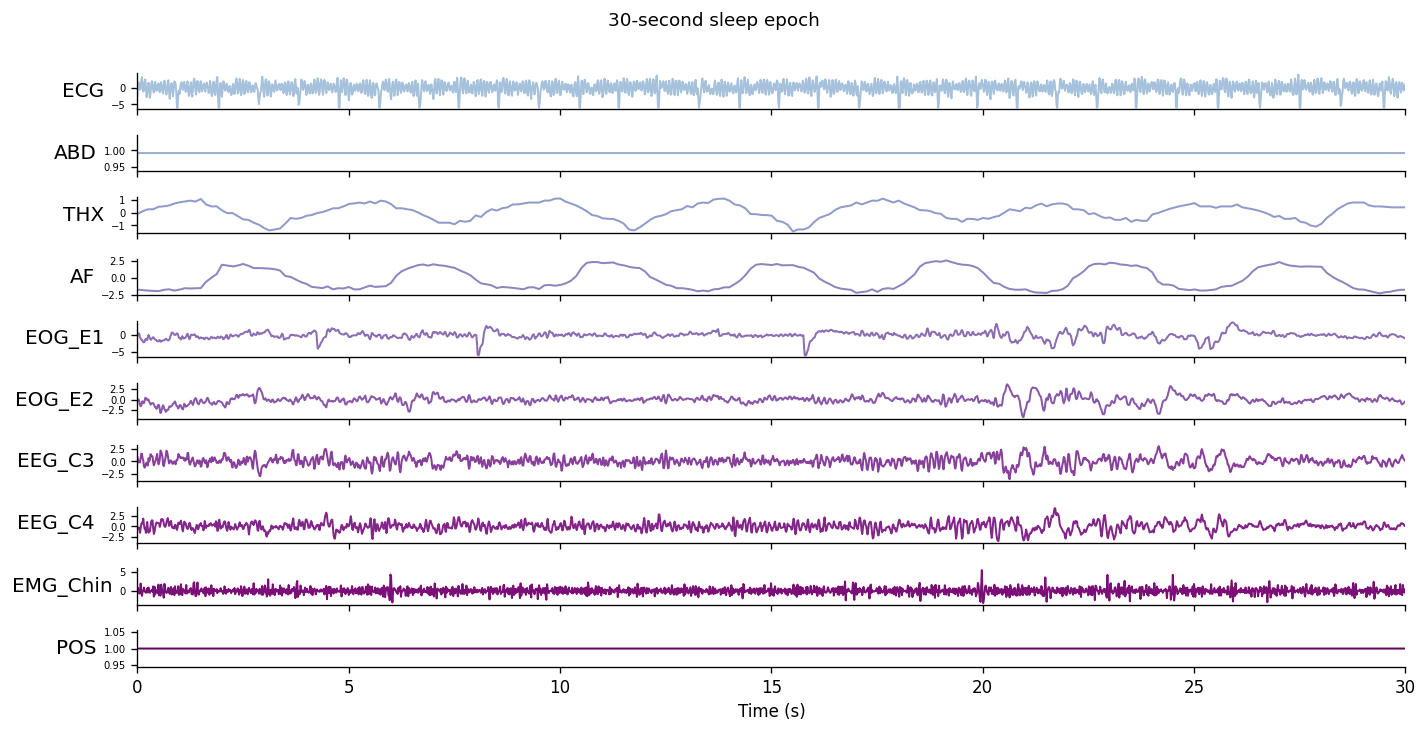

In [6]:
def plot_epoch(signal, sample_idx=0, title=None):
    """Plot all 10 channels of a 30-s epoch."""
    C, T = signal.shape
    t = np.linspace(0, 30, T)
    fig, axes = plt.subplots(C, 1, figsize=(12, 0.6 * C), sharex=True)
    colors = plt.cm.BuPu(np.linspace(0.35, 0.95, C))
    for c in range(C):
        ax = axes[c]
        y = signal[c].numpy()
        ax.plot(t, y, linewidth=1.2, color=colors[c])
        ax.set_ylabel(CHANNEL_NAMES[c], fontsize=12, rotation=0, ha="right", va="center")
        ax.tick_params(axis="y", labelsize=6)
        ax.set_xlim(0, 30)
    axes[-1].set_xlabel("Time (s)")
    fig.suptitle(title or f"30-second sleep epoch",
                 fontsize=11, y=1.01)
    fig.tight_layout()
    plt.show()

plot_epoch(signals[0], 0)

---
## 1. Signal–Text Retrieval & Embedding Similarity

The model maps both sleep signals and text into a shared embedding space via contrastive learning.  
Given *N* signals and *M* text descriptions, we can compute an *N × M* similarity matrix and use it for retrieval.

### 1a. Encode signals & texts

In [7]:
N_SIG = 4
sig_feats = encode_signals(signals[:N_SIG])

# Concatenate stage_event and brain captions as ground truth caption to stay within context length
gt_texts = [c["gt"]["stage_event"] + " " + c["gt"]["brain"] for c in captions[:N_SIG]]
txt_feats = encode_texts(gt_texts)

print(f"Signal embeddings : {sig_feats.shape}")
print(f"Text embeddings   : {txt_feats.shape}")

Signal embeddings : torch.Size([4, 512])
Text embeddings   : torch.Size([4, 512])


### 1b. Similarity matrix 📊 

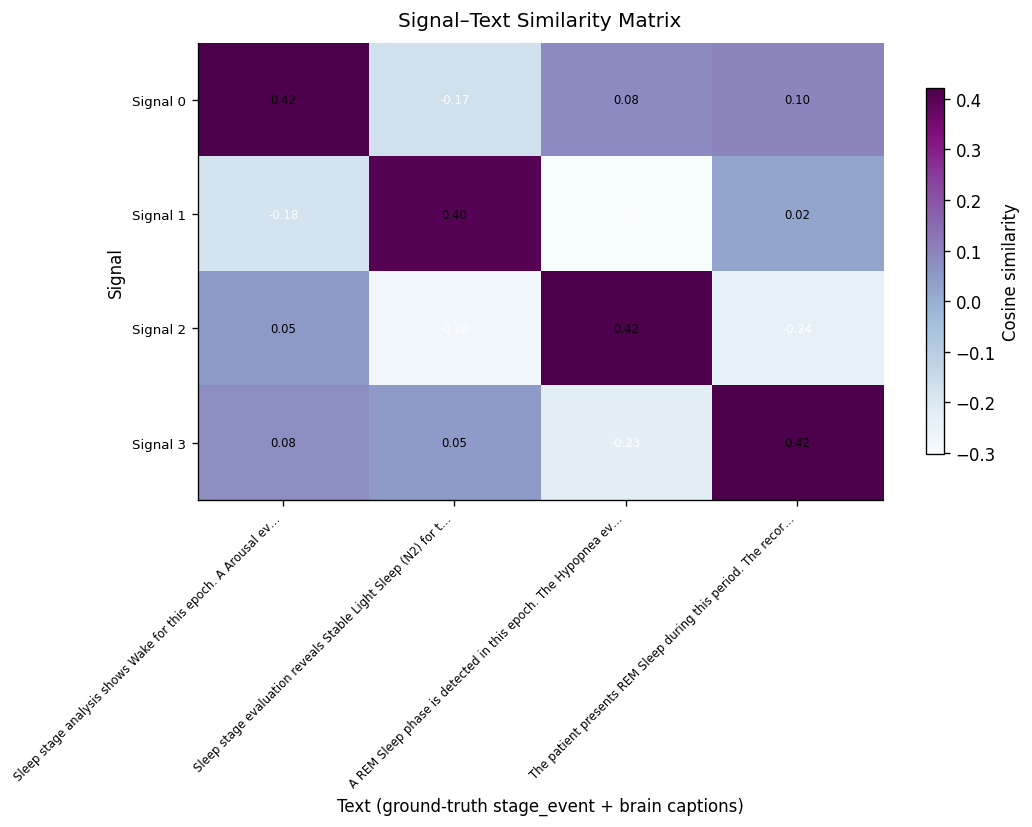

In [8]:
sim = (sig_feats @ txt_feats.T).numpy()

fig, ax = plt.subplots(figsize=(9, 7))
im = ax.imshow(sim, cmap="BuPu", vmin=sim.min(), vmax=sim.max(), aspect="auto")

# Truncate long captions for axis labels
short = [t[:60] + "…" if len(t) > 60 else t for t in gt_texts]

ax.set_xticks(range(N_SIG))
ax.set_xticklabels(short, rotation=45, ha="right", fontsize=7)
ax.set_yticks(range(N_SIG))
ax.set_yticklabels([f"Signal {i}" for i in range(N_SIG)], fontsize=8)

for i in range(N_SIG):
    for j in range(N_SIG):
        color = "white" if abs(sim[i, j] - sim.min()) < 0.3 * (sim.max() - sim.min()) else "black"
        ax.text(j, i, f"{sim[i,j]:.2f}", ha="center", va="center", fontsize=7, color=color)

fig.colorbar(im, ax=ax, shrink=0.8, label="Cosine similarity")
ax.set_xlabel("Text (ground-truth stage_event + brain captions)")
ax.set_ylabel("Signal")
ax.set_title("Signal–Text Similarity Matrix", fontsize=12, pad=10)
fig.tight_layout()
plt.show()

---
## 2. Targeted Caption Generation

The decoder can be **conditioned on a modality token** to produce descriptions focused on a specific aspect of the signal:

| Token | Description |
|---|---|
| `Stage & Event` | Sleep stage + clinical events |
| `Brain` | EEG / EOG activity |
| `Cardiac` | ECG, heart rate, SpO₂ |
| `Respiration` | Airflow, thoracic/abdominal respiration |
| `Somatic` | Body position, chin EMG |

In [9]:
MODALITIES = ["stage_event", "brain", "heart", "respiratory", "position_muscle"]
MOD_LABELS = ["Stage & Events", "Brain", "Cardiac",
              "Respiration", "Somatic"]
MOD_COLORS = ["#5B8DEE", "#E87D5D", "#6EC87A", "#C47DD0", "#D4A94B"]

### 2a — Generate captions for a single epoch

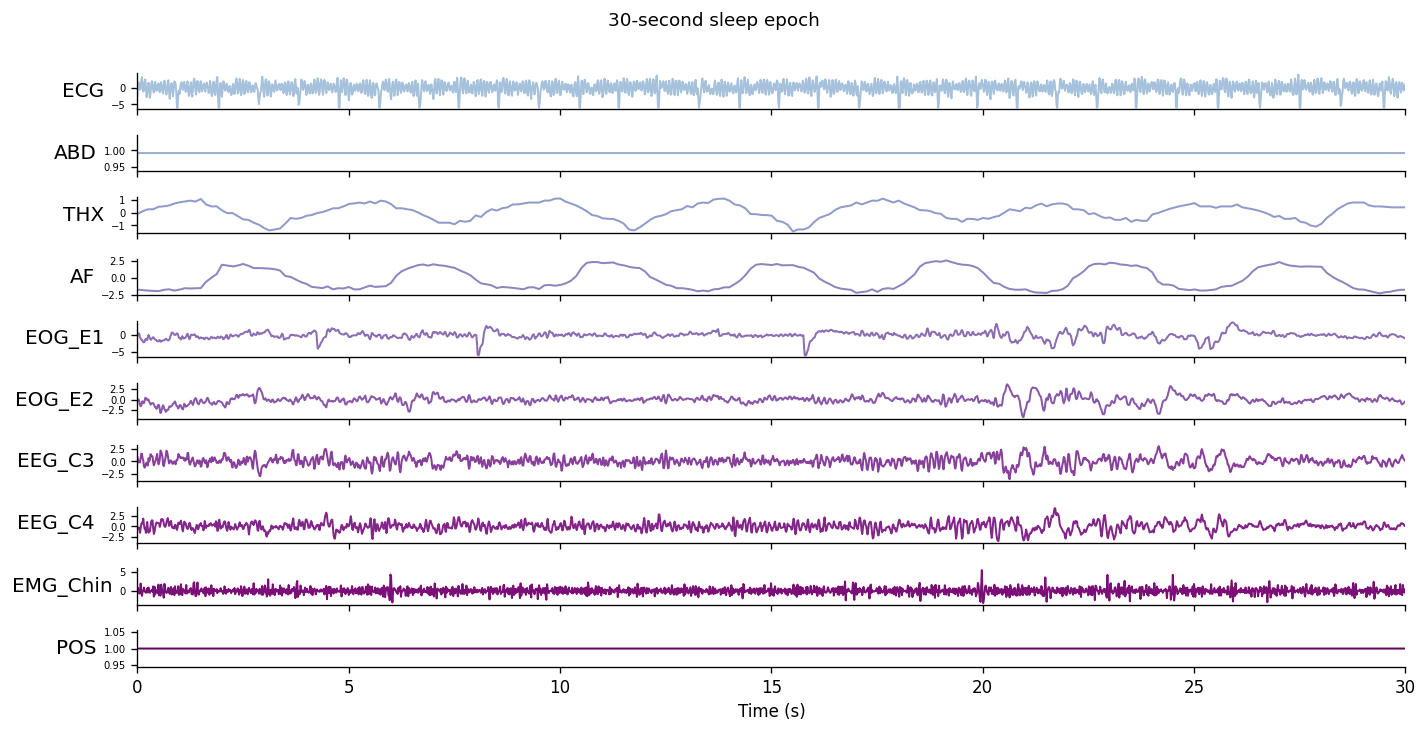

`BeamSearchScorer` is deprecated and will be removed in v4.62.0, as constrained beam search has been moved to the Hub: https://hf.co/transformers-community/constrained-beam-search.
`BeamHypotheses` is deprecated and will be removed in v4.62.0, as constrained beam search has been moved to the Hub: https://hf.co/transformers-community/constrained-beam-search.


Generating captions …



In [10]:
SAMPLE = 0
plot_epoch(signals[SAMPLE], SAMPLE)

print("Generating captions …\n")
preds = {}
for mod in MODALITIES:
    preds[mod] = generate_caption(signals[SAMPLE], mod)

gt = captions[SAMPLE]["gt"] if captions and SAMPLE < len(captions) else None

In [11]:
def render_caption_table(preds, gt, mod_labels, mod_keys, colors):
    """Render a styled HTML table of captions. GT is optional (pass None if unavailable)."""
    rows = ""
    for label, key, c in zip(mod_labels, mod_keys, colors):
        gt_cell = f'<td style="padding:6px 10px; font-size:13px; color:#555;">{gt[key]}</td>' if gt else ""
        rows += f"""
        <tr>
          <td style="font-weight:600; color:{c}; width:140px; vertical-align:top; padding:6px 10px;">{label}</td>
          <td style="padding:6px 10px; font-size:13px;">{preds[key]}</td>
          {gt_cell}
        </tr>"""
    
    gt_header = '<th style="text-align:left; padding:6px 10px; color:#555;">Ground Truth</th>' if gt else ""
    return HTML(f"""
    <table style="border-collapse:collapse; width:100%; margin:10px 0;">
      <thead>
        <tr style="border-bottom:2px solid #333;">
          <th style="text-align:left; padding:6px 10px;">Modality</th>
          <th style="text-align:left; padding:6px 10px;">Generated</th>
          {gt_header}
        </tr>
      </thead>
      <tbody>{rows}</tbody>
    </table>""")

# render_caption_table(preds, gt, MOD_LABELS, MODALITIES, MOD_COLORS)
render_caption_table(preds, None, MOD_LABELS, MODALITIES, MOD_COLORS)

Modality,Generated
Stage & Events,the patient exhibits wake features in this segment . the arousal event is identified from 0 . 0 to 1 5 . 2 seconds .
Brain,"central eeg activity ( c 4 - a 1 ): a delta relative power equal to 3 9 . 0 5 %, together with a theta relative power at 2 8 . 2 0 %, and a beta relative power of 6 . 2 7 %. left eog movement : slow eye movement relative power valued at 2 0 . 5 1 %, and rem saccadic relative power of 5 7 . 2 0 %. central eeg activity ( c 3 - a 2 ): a delta relative power equal to 4 8 . 4 6 %, including a theta relative power of 2 4 . 1 8 %, and a beta relative power of 4 . 8 7 %. right eog movement : slow eye movement relative power of 1 7 . 0 8 %, and rem saccadic relative power equal to 5 6 . 0 5 %."
Cardiac,"heart rate : minimum value of 6 4 . 0 7 , in addition to maximum value of 6 5 . 6 3 , plus a mean of 6 5 . 0 0 , an increasing behavior from 1 4 . 1 to 1 8 . 8 seconds , and a decreasing interval from 2 5 . 3 to 3 0 . 0 seconds . blood oxygen saturation : minimum value of 9 8 . 0 5 , and a mean of 9 8 . 0 5 ."
Respiration,"thoracic respiration : respiratory rate of 1 4 . 7 1 bpm , and breath interval variability equal to 0 . 2 5 s . abdominal respiration : respiratory rate of 1 3 . 2 9 bpm . air flow : airflow rate of 1 4 . 6 1 bpm , and inspiratory flow flatness of 0 . 7 2 ."
Somatic,"chin emg activity : median frequency of 1 7 . 3 0 hz , in addition to burst intensity ratio equal to 1 . 9 4 , and a burst modulation rate equal to 0 . 9 6 hz . the patient stays lying left for the full epoch ."
